# Example 4: DIS rectangular model

##### To avoid confusion of the different IDs used: 
- Each model grid cell has an id (Cellid)
- If the cell has a UZF object, this UZF object will have another id (UZF_IFNO).
- If the cell has an SFR object, this SFR object will have another id (SFR_IFNO).
- The provider objects are always UZF objects (UZF cells).
- The receiver objects are either UZF cells or SFR reaches and can also be objects of other packages (e.g. LAK, WEL, etc).

##### The main steps to calculate the flow fractions are the following:
1. Load the discretization package and export the grid to a shapefile.
2. Load the provider package (UZF package) with the Cellid and the IFNO of each provider (UZF cell).
3. Get the neighbour cells to each grid cell.
4. Get the Cellid and IFNO of the receivers (UZF cells).
5. Calculate the distance between each cell and all its neighbour (connected) cells.
6. Calculate the slope between each cell and all its neighbour (connected) cells.
7. Sum the slopes of all neighbour (connected) cells to each cell.
8. Calculate the flow fraction from each cell to all its neighbour (connected) cells.
9. Adapt the calculations to the MOVER (MVR) package format.
10. Change the ID of the receivers in case the receivers are not UZF cells (e.g. SFR reaches).

In [1]:
import os
import sys
import shutil
import flopy
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
startTime = datetime.now()

#### Setup the working directory

In [3]:
root = os.path.join('.')
foldername = 'ex4_DIS_rectangle'
model_ws = os.path.join(root, foldername)
shapefiles_ws = os.path.join(root, 'shapefiles')
if not os.path.exists(shapefiles_ws):
    os.makedirs(shapefiles_ws)

In [4]:
sim_name = 'mfsim.nam'
exe_name = os.path.join(model_ws, 'mf6')
sim = flopy.mf6.MFSimulation.load(sim_name = sim_name, version= 'mf6', exe_name = exe_name, sim_ws = model_ws)
gwf = sim.get_model(sim.model_names[0])

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package obs...
    loading package sto...
    loading package oc...
    loading package chd...
    loading package drn...
    loading package rch...
    loading package uzf...
  loading solution package modflow...


#### 1. Load the discretization package and export the grid to a shapefile

In [5]:
# the next line works with whatever discretization package is used (DIS, DISV, DISU)
gwf.dis

# activate the below if you want to define the crs
'''
crs = gwf.modelgrid.crs
if crs is None:
    crs = 32734
    gwf.modelgrid.crs = crs
'''    

'\ncrs = gwf.modelgrid.crs\nif crs is None:\n    crs = 32734\n    gwf.modelgrid.crs = crs\n'

In [6]:
# export grid to shapefile
gridshp = gwf.dis.export(os.path.join(shapefiles_ws, 'grid_ex4.shp'))
# read the exported shapefile in a geopandas format
gridshp = gpd.read_file(os.path.join(root, 'shapefiles', 'grid_ex4.shp'))

C:\Users\DaoudMGM\Anaconda3\envs\Work\lib\site-packages\flopy\export\shapefile_utils.py:319: UserWarning: Failed to get data for delc array, dis package
  warn(
C:\Users\DaoudMGM\Anaconda3\envs\Work\lib\site-packages\flopy\export\shapefile_utils.py:319: UserWarning: Failed to get data for delr array, dis package
  warn(
C:\Users\DaoudMGM\Anaconda3\envs\Work\lib\site-packages\flopy\mf6\mfbase.py:468: DeprecationWarning: package_key_dict has been deprecated, use package_type_dict instead
  warnings.warn(


No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.
No CRS information for writing a .prj file.
Supply an valid coordinate system reference to the attached modelgrid object or .export() method.


<Axes: >

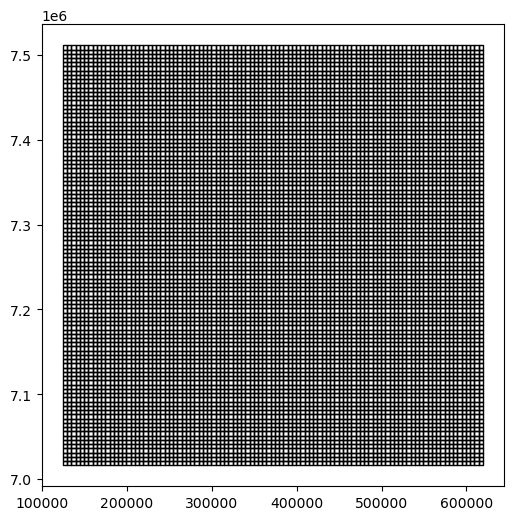

In [7]:
fig, ax = plt.subplots(figsize = (8, 6)) 
gridshp.plot(ax = ax, facecolor = "none")

In [8]:
# make a copy of the geometry column (will be needed later to get the connected cells to each cell)
gridshp['geometry2'] = gridshp['geometry']

#### 2. Load the provider package (UZF package) with the Cellid and the IFNO of each provider (UZF cell) 
##### Add the Cellid and the IFNO to the model grid shapefile

In [9]:
# Get the ifno and cell id of the UZF package and add 1 to all the numbers (since Python is zero-based)
uzf_packagedata = gwf.uzf.packagedata.get_data()
uzf_ifno = uzf_packagedata.ifno + (1)
cellid_0 = uzf_packagedata.cellid
cellid = []

if len(cellid_0[0]) == 1:          # in case of DISU package
    for id in cellid_0:
        id = list(id)
        id[0] = id[0] + 1
        id = tuple(id)
        cellid.append((id))    
elif len(cellid_0[0]) == 2:         # in case of DISV package
    for nlay, id in cellid_0:
        nlay = nlay + 1
        id = id + 1
        cellid.append((nlay, id))
else:                               # in case of DIS package
    for nlay, nrow, ncol in cellid_0:
        nlay = nlay + 1
        nrow = nrow + 1
        ncol = ncol + 1
        cellid.append((nlay, nrow, ncol))     

In [10]:
# add the UZF data (ifno, cellid) to the model grid geopandas
uzf_data = pd.DataFrame([uzf_ifno, cellid]).T
gridshp["uzf_ifno"] = uzf_data[0]
gridshp["cellid"] = uzf_data[1]
gridshp.head()

,node,row,column,botm_1,botm_2,botm_3,botm_4,botm_5,botm_6,idomain_1,idomain_2,idomain_3,idomain_4,idomain_5,idomain_6,top,geometry,geometry2,uzf_ifno,cellid
0,1,1,1,1218.199959,1218.199959,1218.199959,1218.199959,1218.199959,1218.199959,0,0,0,0,0,0,1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...","POLYGON ((124299.651 7511231.898, 129299.651 7...",1,"(1, 1, 76)"
1,2,1,2,1218.199959,1218.199959,1218.199959,1218.199959,1218.199959,1218.199959,0,0,0,0,0,0,1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...","POLYGON ((129299.651 7511231.898, 134299.651 7...",2,"(1, 1, 77)"
2,3,1,3,1268.199959,1268.199959,1268.199959,1268.199959,1268.199959,1268.199959,0,0,0,0,0,0,1347.0,"POLYGON ((134299.651 7511231.898, 139299.651 7...","POLYGON ((134299.651 7511231.898, 139299.651 7...",3,"(1, 1, 78)"
3,4,1,4,1268.199959,1268.199959,1268.199959,1268.199959,1268.199959,1268.199959,0,0,0,0,0,0,1347.0,"POLYGON ((139299.651 7511231.898, 144299.651 7...","POLYGON ((139299.651 7511231.898, 144299.651 7...",4,"(1, 1, 79)"
4,5,1,5,1268.199959,1268.199959,1268.199959,1268.199959,1268.199959,1268.199959,0,0,0,0,0,0,1347.0,"POLYGON ((144299.651 7511231.898, 149299.651 7...","POLYGON ((144299.651 7511231.898, 149299.651 7...",5,"(1, 1, 80)"


#### 3. Get the neighbour cells (right_cells) to each grid cell (left_cell) 
##### Spatial join between the gridshp and itself

In [11]:
gridshp = gpd.sjoin(gridshp, gridshp, how = 'inner')

In [12]:
# check the grid geopandas columns
# after the spatial join, all the columns will have either 'left' or 'right' in their names
# columns with 'left' mean the cell itself and columns with 'right' mean the connected cell
gridshp.columns

Index(['node_left', 'row_left', 'column_left', 'botm_1_left', 'botm_2_left',
       'botm_3_left', 'botm_4_left', 'botm_5_left', 'botm_6_left',
       'idomain_1_left', 'idomain_2_left', 'idomain_3_left', 'idomain_4_left',
       'idomain_5_left', 'idomain_6_left', 'top_left', 'geometry',
       'geometry2_left', 'uzf_ifno_left', 'cellid_left', 'index_right',
       'node_right', 'row_right', 'column_right', 'botm_1_right',
       'botm_2_right', 'botm_3_right', 'botm_4_right', 'botm_5_right',
       'botm_6_right', 'idomain_1_right', 'idomain_2_right', 'idomain_3_right',
       'idomain_4_right', 'idomain_5_right', 'idomain_6_right', 'top_right',
       'geometry2_right', 'uzf_ifno_right', 'cellid_right'],
      dtype='object')

In [13]:
# Do some cleaning of the geopandas attribute data
# Continue with the necessary columns only
gridshp = gridshp[['node_left', 'uzf_ifno_left', 'cellid_left', 'top_left', 'geometry', 'node_right', 'cellid_right', 'top_right', 'geometry2_right']]
# Sort values
gridshp.sort_values(['node_left', 'node_right'], inplace = True)
# Remove the cells that are  
gridshp = gridshp[gridshp['node_left'] != gridshp['node_right']]
# get the centroid of each cell (left cells)
gridshp['centroid_left'] = gridshp.centroid
# Rename some columns
gridshp.rename_geometry('geometry_left', inplace = True)
gridshp.rename(columns ={'geometry2_right' : 'geometry_right'}, inplace = True)
gridshp.dropna(subset = ['cellid_right'], inplace= True)
gridshp.head()

,node_left,uzf_ifno_left,cellid_left,top_left,geometry_left,node_right,cellid_right,top_right,geometry_right,centroid_left
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",POINT (126799.651 7508731.898)
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",100,"(1, 5, 80)",1297.0,"POLYGON ((124299.651 7506231.898, 129299.651 7...",POINT (126799.651 7508731.898)
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",101,"(1, 5, 81)",1297.0,"POLYGON ((129299.651 7506231.898, 134299.651 7...",POINT (126799.651 7508731.898)
1,2,2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",POINT (131799.651 7508731.898)
1,2,2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",3,"(1, 1, 78)",1347.0,"POLYGON ((134299.651 7511231.898, 139299.651 7...",POINT (131799.651 7508731.898)


#### 4. Get the Cellid and IFNO of the receivers (UZF cells)
##### Create a new geopandas with the geometry of the connected cells (right_cells)

In [14]:
gridshp2 = gpd.GeoDataFrame(gridshp["node_right"], geometry = gridshp["geometry_right"])
gridshp2['centroid_right'] = gridshp2.centroid # get the centroid of each cell (right cells)
gridshp2.rename_geometry('geometry_right', inplace = True) # rename column
gridshp2.head()

,node_right,geometry_right,centroid_right
0,2,"POLYGON ((129299.651 7511231.898, 134299.651 7...",POINT (131799.651 7508731.898)
0,100,"POLYGON ((124299.651 7506231.898, 129299.651 7...",POINT (126799.651 7503731.898)
0,101,"POLYGON ((129299.651 7506231.898, 134299.651 7...",POINT (131799.651 7503731.898)
1,1,"POLYGON ((124299.651 7511231.898, 129299.651 7...",POINT (126799.651 7508731.898)
1,3,"POLYGON ((134299.651 7511231.898, 139299.651 7...",POINT (136799.651 7508731.898)


#### 5. Calculate the distance between each cell (left_cell) and all its neighbour (connected) cells (right_cells)

In [15]:
gridshp["distance"] = gridshp['centroid_left'].distance(gridshp2['centroid_right'])
gridshp.head()

,node_left,uzf_ifno_left,cellid_left,top_left,geometry_left,node_right,cellid_right,top_right,geometry_right,centroid_left,distance
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",POINT (126799.651 7508731.898),5000.000000
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",100,"(1, 5, 80)",1297.0,"POLYGON ((124299.651 7506231.898, 129299.651 7...",POINT (126799.651 7508731.898),5000.000000
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",101,"(1, 5, 81)",1297.0,"POLYGON ((129299.651 7506231.898, 134299.651 7...",POINT (126799.651 7508731.898),7071.067812
1,2,2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",POINT (131799.651 7508731.898),5000.000000
1,2,2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",3,"(1, 1, 78)",1347.0,"POLYGON ((134299.651 7511231.898, 139299.651 7...",POINT (131799.651 7508731.898),5000.000000


#### 6. Calculate the slope between each cell (left_cell) and all its neighbour (connected) cells (right_cells)

In [16]:
gridshp["slope"] = (gridshp['top_left'] - gridshp['top_right']) / gridshp['distance'] * 100
gridshp.loc[gridshp['slope'] <= 0, 'slope'] = 0
gridshp.head()

,node_left,uzf_ifno_left,cellid_left,top_left,geometry_left,node_right,cellid_right,top_right,geometry_right,centroid_left,distance,slope
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",POINT (126799.651 7508731.898),5000.000000,0.0
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",100,"(1, 5, 80)",1297.0,"POLYGON ((124299.651 7506231.898, 129299.651 7...",POINT (126799.651 7508731.898),5000.000000,0.0
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",101,"(1, 5, 81)",1297.0,"POLYGON ((129299.651 7506231.898, 134299.651 7...",POINT (126799.651 7508731.898),7071.067812,0.0
1,2,2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",POINT (131799.651 7508731.898),5000.000000,0.0
1,2,2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",3,"(1, 1, 78)",1347.0,"POLYGON ((134299.651 7511231.898, 139299.651 7...",POINT (131799.651 7508731.898),5000.000000,0.0


#### 7. Sum the slopes of all neighbour ((right cells)) cells to each cell (left cell)

In [17]:
gridshp["sum_slopes"] = gridshp.groupby(gridshp.index).slope.sum()
gridshp.head()

,node_left,uzf_ifno_left,cellid_left,top_left,geometry_left,node_right,cellid_right,top_right,geometry_right,centroid_left,distance,slope,sum_slopes
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",POINT (126799.651 7508731.898),5000.000000,0.0,0.0
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",100,"(1, 5, 80)",1297.0,"POLYGON ((124299.651 7506231.898, 129299.651 7...",POINT (126799.651 7508731.898),5000.000000,0.0,0.0
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",101,"(1, 5, 81)",1297.0,"POLYGON ((129299.651 7506231.898, 134299.651 7...",POINT (126799.651 7508731.898),7071.067812,0.0,0.0
1,2,2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",POINT (131799.651 7508731.898),5000.000000,0.0,0.0
1,2,2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",3,"(1, 1, 78)",1347.0,"POLYGON ((134299.651 7511231.898, 139299.651 7...",POINT (131799.651 7508731.898),5000.000000,0.0,0.0


#### 8. Calculate the flow fraction from each cell (left cell) to all its neighbour (connected) cells (right cells)

In [18]:
gridshp["flow_fraction"] = gridshp["slope"] / gridshp["sum_slopes"]
gridshp["flow_fraction"] = round(gridshp["flow_fraction"], 3)
gridshp.head()

,node_left,uzf_ifno_left,cellid_left,top_left,geometry_left,node_right,cellid_right,top_right,geometry_right,centroid_left,distance,slope,sum_slopes,flow_fraction
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",POINT (126799.651 7508731.898),5000.000000,0.0,0.0,NaN
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",100,"(1, 5, 80)",1297.0,"POLYGON ((124299.651 7506231.898, 129299.651 7...",POINT (126799.651 7508731.898),5000.000000,0.0,0.0,NaN
0,1,1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",101,"(1, 5, 81)",1297.0,"POLYGON ((129299.651 7506231.898, 134299.651 7...",POINT (126799.651 7508731.898),7071.067812,0.0,0.0,NaN
1,2,2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",1,"(1, 1, 76)",1297.0,"POLYGON ((124299.651 7511231.898, 129299.651 7...",POINT (131799.651 7508731.898),5000.000000,0.0,0.0,NaN
1,2,2,"(1, 1, 77)",1297.0,"POLYGON ((129299.651 7511231.898, 134299.651 7...",3,"(1, 1, 78)",1347.0,"POLYGON ((134299.651 7511231.898, 139299.651 7...",POINT (131799.651 7508731.898),5000.000000,0.0,0.0,NaN


#### 9. Adapt the calculations to the MOVER (MVR) package format (with the necessary columns only)

In [19]:
mvr_data = gridshp[['node_left', 'uzf_ifno_left', 'cellid_left', 'node_right', 'cellid_right', 'flow_fraction']]
mvr_data.head()

,node_left,uzf_ifno_left,cellid_left,node_right,cellid_right,flow_fraction
0,1,1,"(1, 1, 76)",2,"(1, 1, 77)",NaN
0,1,1,"(1, 1, 76)",100,"(1, 5, 80)",NaN
0,1,1,"(1, 1, 76)",101,"(1, 5, 81)",NaN
1,2,2,"(1, 1, 77)",1,"(1, 1, 76)",NaN
1,2,2,"(1, 1, 77)",3,"(1, 1, 78)",NaN


In [20]:
# drop zero and NaN flow fraction
mvr_data = mvr_data[mvr_data['flow_fraction'] != 0]
mvr_data.dropna(subset = ['flow_fraction'], inplace= True)
mvr_data.head()

,node_left,uzf_ifno_left,cellid_left,node_right,cellid_right,flow_fraction
2,3,3,"(1, 1, 78)",2,"(1, 1, 77)",0.369
2,3,3,"(1, 1, 78)",101,"(1, 5, 81)",0.261
2,3,3,"(1, 1, 78)",102,"(1, 5, 82)",0.369
3,4,4,"(1, 1, 79)",102,"(1, 5, 82)",1.000
8,9,9,"(1, 1, 84)",10,"(1, 1, 85)",1.000


#### 10. Change the ID of the receivers in case the receivers are not UZF cells (e.g. SFR reaches)

In [21]:
sfr_package = ['sfr', 'sfr_0']
sfr_check = False
for pak in sfr_package:
    if pak in gwf.package_names:
        sfr_check = True
sfr_check

False

#### No SFR package found in this model

#### Add package names

In [25]:
mvr_data['provider_package'] = 'UZF'
mvr_data['reciever_package'] = 'UZF'
mvr_data.rename(columns ={'node_left' : 'provider_id'}, inplace = True)
mvr_data.rename(columns ={'node_right' : 'reciever_id'}, inplace = True)
mvr_data = mvr_data[['provider_package', 'provider_id', 'reciever_package', 'reciever_id', 'flow_fraction']]
mvr_data

,provider_package,provider_id,reciever_package,reciever_id,flow_fraction
2,UZF,3,UZF,2,0.369
2,UZF,3,UZF,101,0.261
2,UZF,3,UZF,102,0.369
3,UZF,4,UZF,102,1.000
8,UZF,9,UZF,10,1.000
...,...,...,...,...,...
9792,UZF,9793,UZF,9794,0.369
9796,UZF,9797,UZF,9796,1.000
9797,UZF,9798,UZF,9797,1.000
9799,UZF,9800,UZF,9700,0.414


In [26]:
# export to txt file
mvr_data.to_csv(os.path.join(model_ws, "mvr_data.txt"), sep = '\t', header = None, index = None)

In [27]:
print ('the script took', datetime.now() - startTime, 'to run')

the script took 0:01:10.003530 to run
